In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_terms = pd.read_csv("/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv",sep="\t")
train_protein_ids = np.load('/kaggle/input/t5embeds/train_ids.npy')
train_terms.shape
train_protein_ids.shape

(142246,)

In [3]:
train_embeddings = np.load('/kaggle/input/t5embeds/train_embeds.npy')

column_num = train_embeddings.shape[1]
train_df = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
train_df.shape

(142246, 1024)

In [4]:
num_of_labels = 1500
labels = train_terms['term'].value_counts().index[:num_of_labels].tolist()

In [5]:
train_terms_updated = train_terms.loc[train_terms['term'].isin(labels)]

In [6]:
train_size = train_protein_ids.shape[0]
train_labels = np.zeros((train_size ,num_of_labels))

series_train_protein_ids = pd.Series(train_protein_ids)

for i in range(num_of_labels):
    n_train_terms = train_terms_updated[train_terms_updated['term'] ==  labels[i]]
    label_related_proteins = n_train_terms['EntryID'].unique()
    
    train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)


labels_df = pd.DataFrame(data = train_labels, columns = labels)
print(labels_df.shape)

(142246, 1500)


In [7]:
"""class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        
        assert d_model % num_heads == 0
        self.depth = d_model // num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        
        # Linear transformations
        q = self.wq(inputs)
        k = self.wk(inputs)
        v = self.wv(inputs)
        
        # Split heads
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        # Scaled dot-product attention
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(self.depth, tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        
        # Concatenate heads
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(output, (batch_size, -1, self.d_model))
        
        # Final linear layer
        output = self.dense(concat_attention)
        return output"""

In [9]:
INPUT_SHAPE = [train_df.shape[1]]
BATCH_SIZE = 5120

inputs = tf.keras.Input(shape=INPUT_SHAPE)

x = tf.keras.layers.BatchNormalization()(inputs)

x = tf.keras.layers.Dense(512, activation='relu')(x)

seq = tf.keras.layers.Reshape((1, 512))(x)

attn_out = tf.keras.layers.MultiHeadAttention(
    num_heads=8,
    key_dim=64,
    name='self_attn'
)(seq, seq)

attn_out = tf.keras.layers.Reshape((512,))(attn_out)

x = tf.keras.layers.Add()([x, attn_out])
x = tf.keras.layers.LayerNormalization()(x)

x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)

outputs = tf.keras.layers.Dense(num_of_labels, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='MLP_with_SelfAttention')

model.summary()

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC()],
)

history = model.fit(
    train_df, labels_df,
    batch_size=BATCH_SIZE,
    epochs=5
)

Model: "MLP_with_SelfAttention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 1024)        4096        ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 dense_6 (Dense)                (None, 512)          524800      ['batch_normalization_1[0][0]']  
                                                                                                  
 reshape_1 (Reshape)            (None, 1, 512)       0           ['dense_6[0]

<AxesSubplot: title={'center': 'Accuracy'}>

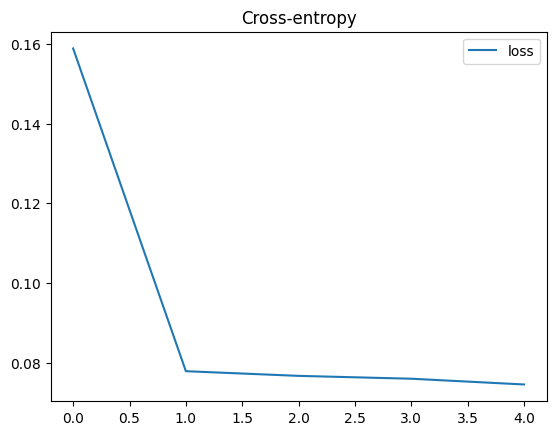

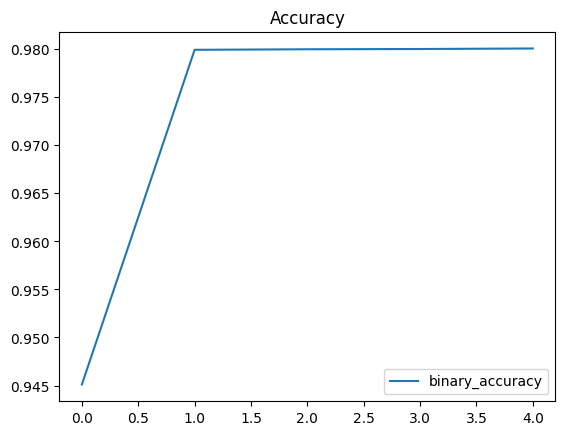

In [10]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy']].plot(title="Accuracy")

In [11]:
test_embeddings = np.load('/kaggle/input/t5embeds/test_embeds.npy')

column_num = test_embeddings.shape[1]
test_df = pd.DataFrame(test_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(test_df.shape)

(141865, 1024)


In [12]:
test_df.head()

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.054705,0.063420,-0.015320,-0.016506,0.042195,0.021592,-0.118535,-0.063298,-0.046146,-0.102311,...,-0.019581,-0.043712,-0.072322,0.002404,0.018459,-0.047278,0.012195,-0.043319,0.036009,0.063093
1,0.090373,0.089842,-0.023887,-0.011446,0.051465,0.020982,-0.110989,-0.066646,-0.041259,-0.087551,...,-0.024399,-0.041957,-0.066329,0.006856,0.028449,-0.053758,0.009699,-0.053350,0.019644,0.079630
2,0.043588,0.039572,-0.014332,-0.011769,0.045109,0.015847,-0.103339,-0.047735,-0.022730,-0.091452,...,-0.029648,-0.037944,-0.046043,0.003603,0.018028,-0.030746,0.003671,-0.044464,0.030974,0.040322
3,0.055668,0.049560,-0.019646,-0.006977,0.039897,0.021177,-0.108079,-0.047191,-0.031517,-0.100057,...,-0.023210,-0.041704,-0.048440,0.006088,0.020110,-0.046751,-0.006635,-0.041455,0.016683,0.057030
4,0.022637,0.014306,-0.002696,-0.034456,0.034854,0.020822,-0.114046,-0.050019,-0.026491,-0.097928,...,-0.019185,-0.032108,-0.051394,0.008448,0.015208,-0.037987,0.030977,-0.042407,0.041232,0.047161


In [13]:
predictions =  model.predict(test_df)

4434/4434 [==============================] - 8s 2ms/step


In [14]:
df_submission = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])
test_protein_ids = np.load('/kaggle/input/t5embeds/test_ids.npy')
l = []
for k in list(test_protein_ids):
    l += [ k] * predictions.shape[1]   

df_submission['Protein Id'] = l
df_submission['GO Term Id'] = labels * predictions.shape[0]
df_submission['Prediction'] = predictions.ravel()
df_submission.to_csv("submission.tsv",header=False, index=False, sep="\t")

In [15]:
df_submission

,Protein Id,GO Term Id,Prediction
0,Q9CQV8,GO:0005575,0.664447
1,Q9CQV8,GO:0008150,0.704410
2,Q9CQV8,GO:0110165,0.639112
3,Q9CQV8,GO:0003674,0.583527
4,Q9CQV8,GO:0005622,0.486766
...,...,...,...
212797495,A0A3G2FQK2,GO:0051783,0.001487
212797496,A0A3G2FQK2,GO:0031674,0.001241
212797497,A0A3G2FQK2,GO:0001818,0.001680
212797498,A0A3G2FQK2,GO:0006874,0.000664
